In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns  # 如果想要更方便地可视化混淆矩阵，可以使用 seaborn
from tqdm import tqdm   # 用于进度条

In [46]:
# -----------------------------------------------------------------------------
# 1. 数据预处理函数
# -----------------------------------------------------------------------------
def preprocess_data(df):
    """
    对数据进行预处理：
    1. 将object类型或可能是字符串类型的特征进行编码（标签编码）
    2. 提取特征X和标签y
    """
    # 假设最后一列class为标签
    # 如果列名为 'class'，则：
    if 'class' not in df.columns:
        raise ValueError("DataFrame 中未找到 'class' 列，请检查数据。")
    # 分离特征和标签
    X = df.drop('class', axis=1)
    y = df['class']
    # 找到所有非数字列，对其进行标签编码
    # 如果你想使用独热编码，可以改成 pd.get_dummies(X, columns=cols)
    non_numeric_cols = X.select_dtypes(include=['object']).columns
    for col in non_numeric_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    return X, y

In [47]:
# -----------------------------------------------------------------------------
# 2. 模型选择函数
# -----------------------------------------------------------------------------
def choose_model(model_name='RF'):
    """
    根据输入的模型名称，返回对应的机器学习模型实例。
    可根据需求在此扩展更多模型。
    """
    model_name = model_name.lower()
    if model_name == 'dt':
        # 决策树
        return DecisionTreeClassifier(random_state=42)
    elif model_name == 'rf':
        # 随机森林
        return RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == 'svm':
        # 支持向量机
        return SVC(kernel='rbf', probability=True, random_state=42)
    elif model_name == 'knn':
        # K近邻
        return KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'gbm':
        # 梯度提升
        return GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    elif model_name == 'lr':
        # 逻辑回归
        return LogisticRegression(max_iter=1000, random_state=42)
    elif model_name == 'xgboost':
        # XGBoost
        return XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    else:
        print(f"未匹配到指定模型 {model_name}，默认使用随机森林 (RF)。")
        return RandomForestClassifier(n_estimators=100, random_state=42)

In [48]:
# -----------------------------------------------------------------------------
# 3. 训练函数
# -----------------------------------------------------------------------------
def train_model(model, train_path):
    """
    使用给定的模型和训练集路径对模型进行训练。
    返回训练好的模型，以及预处理后的训练特征和标签。
    """
    print(f"开始加载训练数据：{train_path}")
    df_train = pd.read_csv(train_path)
    print("开始对训练数据进行预处理...")
    X_train, y_train = preprocess_data(df_train)
    print("开始训练模型...")
    # 这里加一个进度条来模拟训练过程；一般情况下，训练过程本身不一定能直接在tqdm中显示（要看模型是否支持迭代输出）
    for _ in tqdm(range(1), desc="Training"):
        model.fit(X_train, y_train)
    print("训练完成！")
    return model, X_train, y_train

In [49]:
# -----------------------------------------------------------------------------
# 4. 测试函数
# -----------------------------------------------------------------------------
def test_model(model, test_path, batch_size=1000):
    """
    使用给定的模型和测试集路径对模型进行测试。
    返回评估指标分数，并可视化混淆矩阵。
    使用批量预测来提升速度，同时保留进度条。
    
    参数:
    - model: 训练好的模型
    - test_path: 测试集CSV文件路径
    - batch_size: 每批预测的数据量大小
    """
    print(f"开始加载测试数据：{test_path}")
    df_test = pd.read_csv(test_path)
    print("开始对测试数据进行预处理...")
    X_test, y_test = preprocess_data(df_test)
    print("开始预测...")
    # 如果不需要进度条，或对小数据集，直接使用 model.predict(X_test) 即可:
    # y_pred = model.predict(X_test)
    #
    # 下面使用批量预测方式 + tqdm 进度条的写法：
    predictions = []
    # range(0, len(X_test), batch_size) 可以把测试集分成若干批次
    for start_idx in tqdm(range(0, len(X_test), batch_size), desc="Predicting"):
        end_idx = min(start_idx + batch_size, len(X_test))
        # 按批次取出数据
        X_batch = X_test.iloc[start_idx:end_idx]
        # 一次预测该批次所有样本
        batch_preds = model.predict(X_batch)
        # 收集到predictions中
        predictions.extend(batch_preds)
    # 转为数组
    y_pred = np.array(predictions)
    # 计算指标
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"\n测试结果：\nAccuracy = {acc:.4f}\nPrecision = {precision:.4f}\nRecall = {recall:.4f}\nF1-Score = {f1:.4f}")
    # 可视化混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return acc, precision, recall, f1

In [50]:
# -----------------------------------------------------------------------------
# 主流程示例
# -----------------------------------------------------------------------------
selected_model_name = 'KNN'  # 'RF', 'SVM', 'KNN', 'GBM', 'DT', 'LR', 'xgboost' 等
model = choose_model(selected_model_name)
# 设置训练集和测试集路径
train_csv_path = "NSL-KDD-Train.csv"
# 训练模型
model, X_train, y_train = train_model(model, train_csv_path)

开始加载训练数据：NSL-KDD-Train.csv
开始对训练数据进行预处理...
开始训练模型...


Training: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]

训练完成！


开始加载测试数据：NSL-KDD-FGSM-Adversarial.csv
开始对测试数据进行预处理...
开始预测...


Predicting: 100%|██████████| 35/35 [00:23<00:00,  1.48it/s]



测试结果：
Accuracy = 0.7007
Precision = 0.8124
Recall = 0.7007
F1-Score = 0.7043


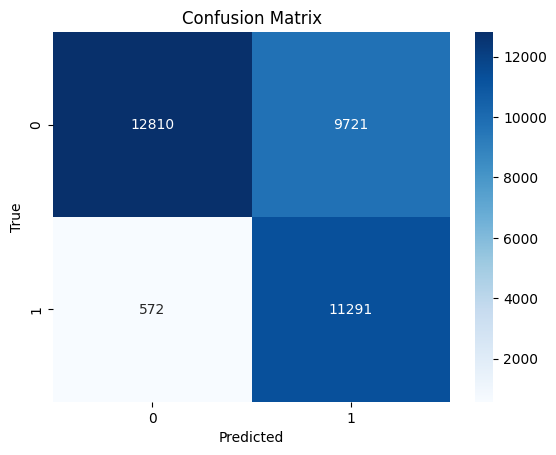

In [51]:
# 测试模型
# 你可以调整batch_size，如1000、5000、甚至一次性预测
test_csv_path = "NSL-KDD-FGSM-Adversarial.csv"  # NSL-KDD-FGSM-Adversarial    NSL-KDD-Test
acc, precision, recall, f1 = test_model(model, test_csv_path, batch_size=1000)